# EDA and Cleaning

## Contents

-  [Data Import and Individual Cleaning](#Data-Import-and-Individual-Cleaning)
-  [Combined Text Cleaning](#Combined-Text-Cleaning)
-  [Visualization: Count Vectorizer](#Visualization:-Count-Vectorizer)
-  [Save Cleaned Data](#Save-Cleaned-Data)

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import nltk
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

nltk.download('wordnet')
sns.set_style('darkgrid')
sns.set_palette(palette='colorblind')
np.random.seed(44)
%matplotlib inline

[nltk_data] Downloading package wordnet to /Users/connie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Import and Individual Cleaning

Given our limitations with the collected twitter data, we will be using CrisisLexT6, an existent labeled dataset that was collected over multiple pass disasters. This will be used moving forward to train our models and provide a text corpus.

In [2]:
sandy_hurricane = pd.read_csv('../data/CrisisLexT6/2012_Sandy_Hurricane/2012_Sandy_Hurricane-ontopic_offtopic.csv')
alberta_floods = pd.read_csv('../data/CrisisLexT6/2013_Alberta_Floods/2013_Alberta_Floods-ontopic_offtopic.csv')
oklahoma_tornado = pd.read_csv('../data/CrisisLexT6/2013_Oklahoma_Tornado/2013_Oklahoma_Tornado-ontopic_offtopic.csv')
queensland_flood = pd.read_csv('../data/CrisisLexT6/2013_Queensland_Floods/2013_Queensland_Floods-ontopic_offtopic.csv')

We define a function to:
-  rename columns
-  add `target` column, where our positive class is `on-topic` (tweet is related to disaster)
-  add `disaster_type` column to differentiate between our disasters

for each dataset.

In [3]:
def process_df(df, disaster_label):
    df.columns = df.columns.str.strip()
    df.rename(columns = {'tweet id': 'id',
                         'tweet': 'text',
                         'label': 'label'}, inplace = True)
    df['label_on-topic'] = df['label'] == 'on-topic'
    df.drop(columns='label', inplace=True)
    df['disaster_type'] = disaster_label

In [4]:
df_list = [sandy_hurricane,
           alberta_floods,
           oklahoma_tornado,
           queensland_flood]

In [5]:
disaster_labels = ['hurricane',
                   'flood',
                   'tornado',
                   'flood']

In [6]:
for df, disaster_label in zip(df_list, disaster_labels):
    process_df(df, disaster_label)

### Combine DataFrames

Combine all processed dataframes into one comprehensive dataframe with each tweet related to its respective disaster.

In [7]:
final_labeled_df = pd.concat([sandy_hurricane, 
                             alberta_floods, 
                             oklahoma_tornado, 
                             queensland_flood])

In [8]:
final_labeled_df.shape

(40064, 4)

We have a total of 40,064 observations and 4 features.

In [9]:
final_labeled_df.head()

,id,text,label_on-topic,disaster_type
0,'262596552399396864',I've got enough candles to supply a Mexican fa...,False,hurricane
1,'263044104500420609',Sandy be soooo mad that she be shattering our ...,True,hurricane
2,'263309629973491712',@ibexgirl thankfully Hurricane Waugh played it...,False,hurricane
3,'263422851133079552',@taos you never got that magnificent case of B...,False,hurricane
4,'262404311223504896',"I'm at Mad River Bar &amp; Grille (New York, N...",False,hurricane


## Combined Text Cleaning

In order to remove any text that will only contribute noise to our model, we will define a function that uses regular expressions to replace certain patterns:

-  **Convert all text to lower case**
-  **Remove additional white sapce**
-  **Remove links:** 
    -  Links starting with `www.` or `https?://:` are replaced with `URL`. Each link is most likely to be unique to the tweet and won't provide any information in regards to the content overall. 
-  **Eliminate hashtags**
-  **Remove `@`** 

In [10]:
def processTweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub('[\s]+', ' ', tweet)
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    tweet = re.sub('@', '', tweet)
    tweet = re.sub('rt', '', tweet)
    return tweet

In [11]:
final_labeled_df['processed'] = [processTweet(i) for i in final_labeled_df['text']]

### Tokenize

We instantiate tokenizer and define the search pattern using `r'\w+` as our regular expression. We only want to search through words and omit digits and symbols.

In [12]:
tokenizer = RegexpTokenizer(r'\w+')

We tokenize the `processed` column and create a new column (`tokenized`) for our results.

In [13]:
final_labeled_df['tokenized'] = final_labeled_df['processed'].map(lambda x: tokenizer.tokenize(x))

### Lemmatize

We will lemmatize our data in an attempt to return the base form of each word.

In [14]:
lemmatizer = WordNetLemmatizer()

We lemmatize the tokenized words in `tokenized` and join them to represent one string again. This is shown in the `lemmatized` column.

In [15]:
final_labeled_df['lemmatized'] = final_labeled_df['tokenized'].map(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))

In [16]:
final_labeled_df.head()

,id,text,label_on-topic,disaster_type,processed,tokenized,lemmatized
0,'262596552399396864',I've got enough candles to supply a Mexican fa...,False,hurricane,i've got enough candles to supply a mexican fa...,"[i, ve, got, enough, candles, to, supply, a, m...",i ve got enough candle to supply a mexican family
1,'263044104500420609',Sandy be soooo mad that she be shattering our ...,True,hurricane,sandy be soooo mad that she be shattering our ...,"[sandy, be, soooo, mad, that, she, be, shatter...",sandy be soooo mad that she be shattering our ...
2,'263309629973491712',@ibexgirl thankfully Hurricane Waugh played it...,False,hurricane,ibexgirl thankfully hurricane waugh played it ...,"[ibexgirl, thankfully, hurricane, waugh, playe...",ibexgirl thankfully hurricane waugh played it ...
3,'263422851133079552',@taos you never got that magnificent case of B...,False,hurricane,taos you never got that magnificent case of bu...,"[taos, you, never, got, that, magnificent, cas...",tao you never got that magnificent case of bur...
4,'262404311223504896',"I'm at Mad River Bar &amp; Grille (New York, N...",False,hurricane,"i'm at mad river bar &amp; grille (new york, ny)","[i, m, at, mad, river, bar, amp, grille, new, ...",i m at mad river bar amp grille new york ny


## Visualization: Count Vectorizer

We want to use CountVectorizer() to quickly visualize the top word counts in our dataset. This will provide some initial insight and what we may expect to see from our modeling.

We instantiate CountVectorizer() and set:
-  `ngram_range = (1, 2)`: Set an upper and lower bound of 1 and 2. Word sequence will contain at least 1 and up to 2 words.
-  `stop_words='english'`: Filter out commonly used words in English
-  `min_df = 25`: Ignore terms that occur in less than 25 documents of the corpus
-  `max_df = 1.0`: There is no maximum threshold since terms cannot have a document frequency greater than `100%`. 

We create a sparse dataframe with all the words in our corpus and their count.

In [17]:
cv = CountVectorizer(ngram_range = (1,2),
                     stop_words = 'english',
                     min_df = 15,
                     max_df = 1.0)

In [18]:
cv_df = pd.SparseDataFrame(cv.fit_transform(final_labeled_df['lemmatized']), 
                           columns = cv.get_feature_names())
cv_df.fillna(0, inplace=True)

In [19]:
cv_df.head()

,00,00 humidity,000,000 evacuated,000 help,000 home,000 people,01,04,10,...,yycflood victim,yycflood yyc,yycflood yychelps,yycfloods,yychelps,yychelps yycflood,zero,zombie,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


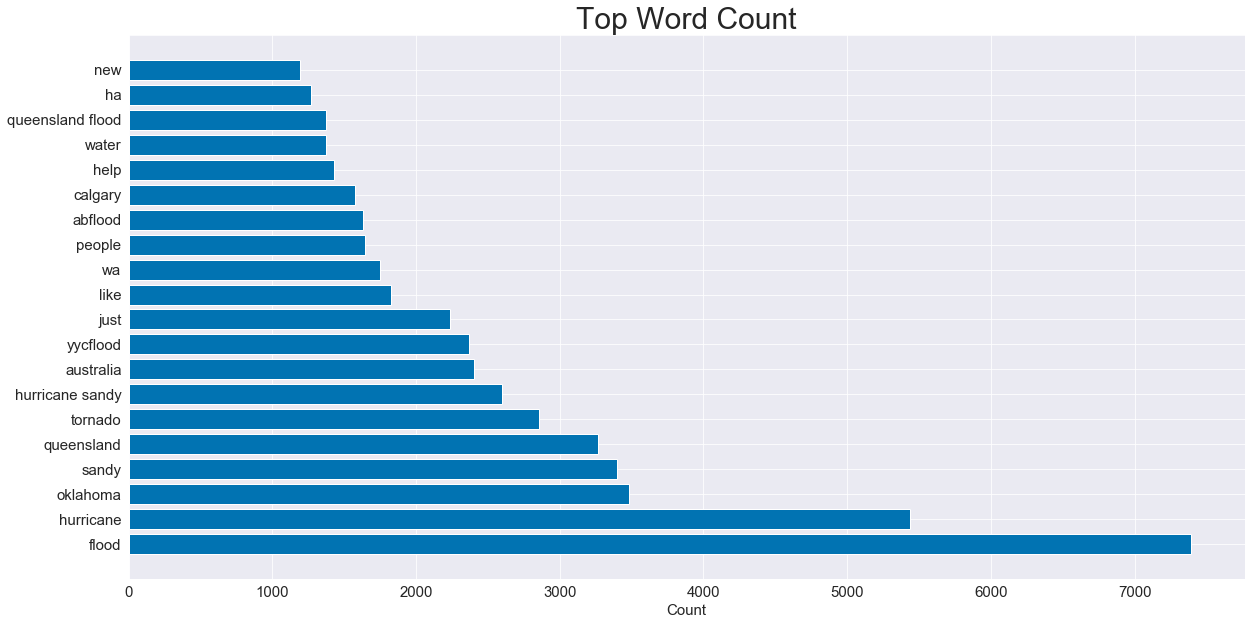

In [20]:
plt.figure(figsize=(20, 10))
plt.barh(y = cv_df.sum().sort_values(ascending=False).head(20).index,
         width = cv_df.sum().sort_values(ascending=False).head(20))
plt.title('Top Word Count', fontsize=30)
plt.xlabel('Count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

-  Almost all of the 20 words either directly refer to the disaster by name or the disaster type.
-  Given that 2 of the 4 disasters were both `disaster_type=flood`, it's reasonable that `flood` has the highest word count.

## Save Cleaned Data

In [21]:
final_labeled_df.to_csv('../data/final_df')